In [1]:
import os
import pandas as pd
import librosa 
import numpy as np
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import keras.models as models
import keras.layers as layers
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import IPython.display as idp
from keras.models import load_model
import cv2
import warnings
warnings.simplefilter("ignore")

In [2]:
audio_dataset_path = 'extracted/'
df = pd.read_csv('extracted/UrbanSound8K.csv')

In [3]:
df.head(5)

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [4]:
classes = df['class'].unique()
print("Classes are: ",classes)
print("# of Classes are: ",classes.shape[0])

Classes are:  ['dog_bark' 'children_playing' 'car_horn' 'air_conditioner' 'street_music'
 'gun_shot' 'siren' 'engine_idling' 'jackhammer' 'drilling']
# of Classes are:  10


In [5]:
X = []
y = []
up_width = 173
up_height = 40
for data in df.iterrows():
    file_name = os.path.join(os.path.abspath(audio_dataset_path),'fold'+str(data[1][5])+'/',str(data[1][0]))
    raw , sr = librosa.load(file_name, res_type='kaiser_fast')
    X_ = librosa.feature.mfcc(y=raw, sr=sr, n_mfcc=40)
    up_points = (up_width, up_height)
    X_ = cv2.resize(X_, up_points, interpolation= cv2.INTER_LINEAR)
    X.append(X_)
    y.append(data[1][7])

In [6]:
X = np.array(X)
y = np.array(y)

In [7]:
print(X.shape)
print(y.shape)

(8732, 40, 173)
(8732,)


In [8]:
y = to_categorical(le.fit_transform(y))
X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)

In [9]:
print("X Shape is: ", X.shape)
print("y Shape is: ", y.shape)

X Shape is:  (8732, 40, 173, 1)
y Shape is:  (8732, 10)


In [10]:
X_train , X_test , y_train , y_test = train_test_split(X , y ,test_size=0.2, random_state=42)

In [11]:
INPUTSHAPE = (40,173,1)

In [41]:
model =  models.Sequential([
    
                          layers.Conv2D(32 , (3,3),activation = 'relu',padding='valid', input_shape = INPUTSHAPE),  
                          layers.MaxPooling2D(2, padding='same'),
                          layers.Conv2D(128, (3,3), activation='relu',padding='valid'),
                          layers.MaxPooling2D(2, padding='same'),
                          layers.Dropout(0.3),
                          layers.Conv2D(128, (3,3), activation='relu',padding='valid'),
                          layers.MaxPooling2D(2, padding='same'),
                          layers.Dropout(0.3),
                          layers.GlobalAveragePooling2D(),
                          layers.Dense(512 , activation = 'relu'),
                          layers.Dense(10 , activation = 'softmax')
])
opt = keras.optimizers.Adam(learning_rate = 0.001)
model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = 'acc')
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_37 (Conv2D)          (None, 38, 171, 32)       320       
                                                                 
 max_pooling2d_37 (MaxPoolin  (None, 19, 86, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_38 (Conv2D)          (None, 17, 84, 128)       36992     
                                                                 
 max_pooling2d_38 (MaxPoolin  (None, 9, 42, 128)       0         
 g2D)                                                            
                                                                 
 dropout_26 (Dropout)        (None, 9, 42, 128)        0         
                                                                 
 conv2d_39 (Conv2D)          (None, 7, 40, 128)      

In [42]:
batch_size = 8
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=8, verbose=0, mode='auto',
    baseline=None, restore_best_weights=False)

history = model.fit(X_train,y_train ,
            validation_data=(X_test,y_test),
            epochs=10,
            callbacks = [callback],batch_size=batch_size)

Epoch 1/10
874/874 [==============================] - 9s 9ms/step - loss: 1.4226 - acc: 0.4926 - val_loss: 1.0879 - val_acc: 0.6291
Epoch 2/10
874/874 [==============================] - 8s 9ms/step - loss: 0.8850 - acc: 0.6942 - val_loss: 0.7866 - val_acc: 0.7212
Epoch 3/10
874/874 [==============================] - 19s 21ms/step - loss: 0.6608 - acc: 0.7749 - val_loss: 0.5461 - val_acc: 0.8163
Epoch 4/10
874/874 [==============================] - 12s 14ms/step - loss: 0.5277 - acc: 0.8272 - val_loss: 0.4763 - val_acc: 0.8443
Epoch 5/10
874/874 [==============================] - 16s 18ms/step - loss: 0.4280 - acc: 0.8534 - val_loss: 0.4153 - val_acc: 0.8598
Epoch 6/10
874/874 [==============================] - 10s 11ms/step - loss: 0.3712 - acc: 0.8772 - val_loss: 0.4089 - val_acc: 0.8655
Epoch 7/10
874/874 [==============================] - 13s 15ms/step - loss: 0.3275 - acc: 0.8880 - val_loss: 0.4050 - val_acc: 0.8678
Epoch 8/10
874/874 [==============================] - 10s 12ms/ste

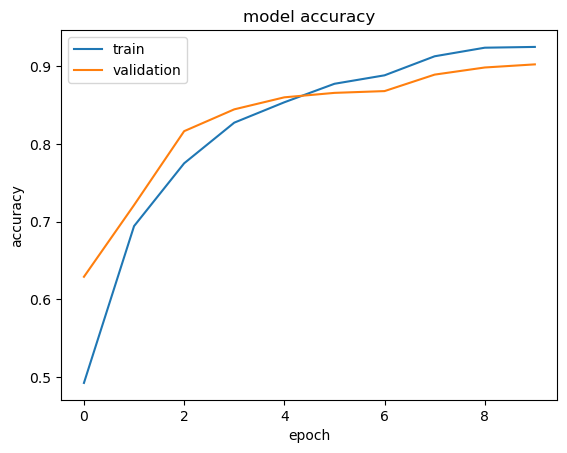

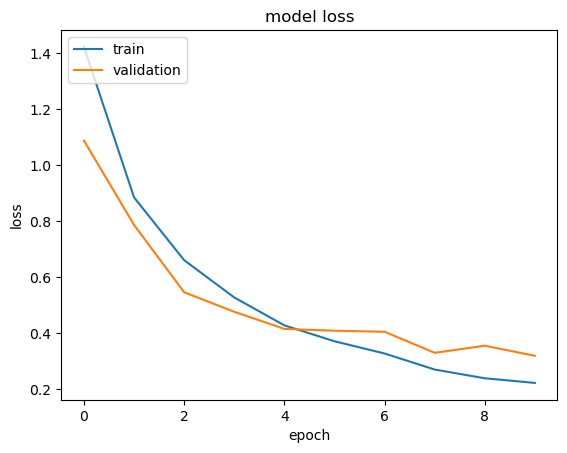

In [43]:
import matplotlib.pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [44]:
model.save('hello')

INFO:tensorflow:Assets written to: hello\assets


INFO:tensorflow:Assets written to: hello\assets


In [45]:
model_saved = keras.models.load_model('hello')

In [46]:
loss, acc = model_saved.evaluate(X_test, y_test, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

55/55 - 1s - loss: 0.3192 - acc: 0.9021 - 704ms/epoch - 13ms/step
Restored model, accuracy: 90.21%


In [47]:
def audio_to_result(filename):
    raw , sr = librosa.load(filename, res_type='kaiser_fast')
    X_image = librosa.feature.mfcc(y=raw, sr=sr, n_mfcc=40)
    up_width = 173
    up_height = 40
    up_points = (up_width, up_height)
    X_image = cv2.resize(X_image, up_points, interpolation= cv2.INTER_LINEAR)
    print(X_image.shape)
    X_image = X_image.reshape(1,X_image.shape[0],X_image.shape[1],1)
    pred = model_saved.predict(X_image)
    prediction = np.argmax(pred, axis=-1)
    return prediction

In [48]:
pred = audio_to_result('extracted/fold3/103199-4-1-0.wav')

(40, 173)
1/1 [==============================] - 0s 68ms/step


In [49]:
pred_class = le.inverse_transform(pred)
print(pred_class[0])

drilling


In [50]:
np.save('classes.npy', le.classes_)